In [2]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle
import glob
import os.path as osp
DATA_DIR = '/mnt/chicm/data/open-images/relation'
DETECT_DATA_DIR = '/mnt/chicm/data/open-images/detect'
IMG_DIR = '/mnt/chicm/data/open-images/train/imgs'
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'

In [3]:
img_files = glob.glob(IMG_DIR + '/**/*.jpg')
fullpath_dict = {}
for fn in img_files:
    fullpath_dict[osp.basename(fn).split('.')[0]] = fn

In [4]:
fullpath_dict['780d8a470d144fa0']

'/mnt/chicm/data/open-images/train/imgs/train_7/780d8a470d144fa0.jpg'

In [8]:
!ls $DATA_DIR

challenge-2019-attributes-description.csv
challenge-2019-classes-vrd.csv
challenge-2019-relationships-description.csv
challenge-2019-relationship-triplets.csv
challenge-2019-train-vrd-bbox.csv
challenge-2019-train-vrd.csv
challenge-2019-train-vrd-labels.csv
challenge-2019-validation-vrd-bbox.csv
challenge-2019-validation-vrd.csv
challenge-2019-validation-vrd-labels.csv
classes_is_42.csv
negative_tuples.csv
top_classes_42.csv
top_classes.csv
VRD_sample_submission.csv


In [5]:
df_classes = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-classes-vrd.csv'), names=['classes', 'desc'])
#df_classes.head()
def get_class_name(label):
    return df_classes.loc[df_classes.classes==label].desc.values[0]

In [6]:
df_box = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd-bbox.csv'))
                     #dtype={'XMin':str, 'XMax':str, 'YMin': str, 'YMax': str})
df_box.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
0,780d8a470d144fa0,/m/04yx4,0.000000,0.527143,0.029979,0.997859,0
1,780d8a470d144fa0,/m/04yx4,0.291429,0.687143,0.128480,0.997859,0
2,780d8a470d144fa0,/m/04yx4,0.590000,0.965714,0.164882,0.997859,0
3,780db0a7d07a4a20,/m/026t6,0.000000,1.000000,0.345625,0.990000,-1
4,780db0a7d07a4a20,/m/026t6,0.271667,0.626667,0.803125,0.999375,0


In [7]:
df_box.shape

(3290070, 7)

In [8]:
df_vrd = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd.csv'))
    #converters={
    #'XMin1':lambda x: '{:.6f}'.format(float(x)),
    #'XMax1':lambda x: '{:.6f}'.format(float(x)),
    #'YMin1':lambda x: '{:.6f}'.format(float(x)),
    #'YMax1':lambda x: '{:.6f}'.format(float(x))})
df_vrd.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
0,fe58ec1b06db2bb7,/m/04bcr3,/m/083vt,0.00500,0.033125,0.580000,0.627778,0.00500,0.033125,0.580000,0.627778,is
1,82d16a22f703df5c,/m/04dr76w,/m/02gy9n,0.61200,0.735000,0.418919,0.950450,0.61200,0.735000,0.418919,0.950450,is
2,b54d41beabcfd900,/m/01mzpv,/m/083vt,0.37250,0.399375,0.706413,0.778557,0.37250,0.399375,0.706413,0.778557,is
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.17125,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.85500,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at


In [13]:
df_vrd.shape

(374768, 12)

In [9]:
df_pos = df_vrd.loc[df_vrd.RelationshipLabel!='is'].copy()

In [10]:
df_pos.RelationshipLabel.value_counts()

at                111493
on                 31604
holds              20986
plays               8932
interacts_with      3756
inside_of           2392
wears                836
hits                 593
under                 34
Name: RelationshipLabel, dtype: int64

In [11]:
print(df_pos.shape, len(df_pos.ImageID.unique()), len(df_pos.LabelName1.unique()),\
      len(df_pos.LabelName2.unique()), len(df_pos.RelationshipLabel.unique()))

(180626, 12) 57187 17 53 9


In [12]:
classes_1 = df_pos.LabelName1.unique()
print(classes_1, len(classes_1))
print([get_class_name(x) for x in classes_1])

['/m/01mzpv' '/m/04yx4' '/m/03bt1vf' '/m/05r655' '/m/01bl7v' '/m/04dr76w'
 '/m/09tvcd' '/m/02p5f1q' '/m/02jvh9' '/m/0dt3t' '/m/0bt9lr' '/m/0cmx8'
 '/m/01599' '/m/04ctx' '/m/01yrx' '/m/01_5g' '/m/03qrc'] 17
['Chair', 'Man', 'Woman', 'Girl', 'Boy', 'Bottle', 'Wine glass', 'Coffee cup', 'Mug', 'Fork', 'Dog', 'Spoon', 'Beer', 'Knife', 'Cat', 'Chopsticks', 'Hamster']


In [13]:
classes_2 = df_pos.LabelName2.unique()
print(classes_2, len(classes_2))
print([get_class_name(x) for x in classes_2])


['/m/01y9k5' '/m/04bcr3' '/m/0199g' '/m/078n6m' '/m/05_5p_0' '/m/01mzpv'
 '/m/0hg7b' '/m/0k4j' '/m/0dv5r' '/m/0dv9c' '/m/0342h' '/m/09tvcd'
 '/m/01226z' '/m/050k8' '/m/0cvnqh' '/m/0bt9lr' '/m/04_sv' '/m/01599'
 '/m/04dr76w' '/m/07y_7' '/m/03ssj5' '/m/080hkjn' '/m/026t6' '/m/02p5f1q'
 '/m/03m3pdh' '/m/03k3r' '/m/0h8my_4' '/m/0wdt60w' '/m/071p9' '/m/0pg52'
 '/m/01940j' '/m/06__v' '/m/05r5c' '/m/0cmx8' '/m/0l14j_' '/m/04ctx'
 '/m/019w40' '/m/01yrx' '/m/0bwd_0j' '/m/01_5g' '/m/0h2r6' '/m/08pbxl'
 '/m/01s55n' '/m/01f91_' '/m/02jvh9' '/m/0584n8' '/m/078jl' '/m/02hj4'
 '/m/05ctyq' '/m/03qrc' '/m/0dt3t' '/m/029bxz' '/m/0fx9l'] 53
['Desk', 'Table', 'Bicycle', 'Coffee table', 'Table tennis racket', 'Chair', 'Microphone', 'Car', 'Camera', 'Racket', 'Guitar', 'Wine glass', 'Football', 'Mobile phone', 'Bench', 'Dog', 'Motorcycle', 'Beer', 'Bottle', 'Violin', 'Bed', 'Handbag', 'Drum', 'Coffee cup', 'Sofa bed', 'Horse', 'Tennis racket', 'Rugby ball', 'Ski', 'Taxi', 'Backpack', 'Snowboard', 'Piano', '

In [14]:
print(set(classes_1) - set(classes_2))

{'/m/03bt1vf', '/m/04yx4', '/m/05r655', '/m/01bl7v'}


In [20]:
df_trip = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip_tuple = df_trip.loc[df_trip.RelationshipLabel!='is']
df_trip_tuple.shape

(287, 3)

In [21]:
pos_img_ids = set(df_pos.ImageID.values)
#len(pos_img_ids)
list(pos_img_ids)[:2]

['2cc0bcb4eb6b65a4', 'df9b5a3dd0a2bb86']

In [23]:
tuple_classes = set(classes_1) | set(classes_2)
print(len(tuple_classes), list(tuple_classes)[:2])

57 ['/m/06__v', '/m/02p5f1q']


In [24]:
len(df_box.ImageID.unique())

790478

In [24]:
df_box_neg = df_box.loc[~df_box.ImageID.isin(pos_img_ids)]
len(df_box_neg.ImageID.unique())

733291

In [25]:
groups = list(df_box_neg.groupby('ImageID'))

In [26]:
groups[0]

('000002b66c9c498e',
                  ImageID  LabelName      XMin      XMax      YMin      YMax  \
 909088  000002b66c9c498e  /m/04bcr3  0.064062  0.492188  0.889063  0.993750   
 909089  000002b66c9c498e  /m/04bcr3  0.301562  0.990625  0.462500  0.595312   
 909090  000002b66c9c498e  /m/04bcr3  0.312500  0.578125  0.351562  0.464063   
 
         IsGroupOf  
 909088          0  
 909089          0  
 909090          0  )

In [27]:
type(groups[0][1].iloc[0].LabelName)

str

In [28]:
groups[0][1]

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
909088,000002b66c9c498e,/m/04bcr3,0.064062,0.492188,0.889063,0.993750,0
909089,000002b66c9c498e,/m/04bcr3,0.301562,0.990625,0.462500,0.595312,0
909090,000002b66c9c498e,/m/04bcr3,0.312500,0.578125,0.351562,0.464063,0


In [29]:
len(groups)

733291

In [30]:
df_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [31]:
import random
def get_neg_sample(group):
    img_id, group = group
    n = len(group.LabelName.values)
    if n < 2:
        return []
    used = set()
    result = []
    for _ in range(20):
        idx1 = random.choice(list(range(n)))
        idx2 = random.choice(list(range(n)))
        if (idx1 != idx2) and ((idx1, idx2) not in used):
            row1 = group.iloc[idx1]
            row2 = group.iloc[idx2]
            label_name1 = row1.LabelName
            label_name2 = row2.LabelName
            if label_name1 in set(classes_1) and label_name2 in set(classes_2):
                result.append({
                    'ImageID': img_id,
                    'LabelName1': label_name1,
                    'LabelName2': label_name2,
                    'XMin1': row1.XMin,
                    'XMax1': row1.XMax,
                    'YMin1': row1.YMin,
                    'YMax1': row1.YMax,
                    'XMin2': row2.XMin,
                    'XMax2': row2.XMax,
                    'YMin2': row2.YMin,
                    'YMax2': row2.YMax,
                    'RelationshipLabel': 'none'
                })
                #result.append((group.iloc[idx1], group.iloc[idx2]))
                used.add((idx1, idx2))
        if len(used) >= 10:
            break
    #print(len(result))
    return result

In [32]:
from multiprocessing import Pool
with Pool(50) as p:
    samples = list(tqdm(iterable=p.imap_unordered(get_neg_sample, groups), total=len(groups)))

100%|██████████| 733291/733291 [03:57<00:00, 3092.82it/s]


In [33]:
neg_samples = []
for results in samples:
    for r in results:
        neg_samples.append(r)

In [34]:
len(neg_samples)

188983

In [35]:
df_neg = pd.DataFrame(neg_samples)
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000201cd362f303,/m/03bt1vf,/m/026t6,none,0.682500,0.167500,0.586875,0.045625,0.591932,0.678236,0.266417,0.537523
1,0000201cd362f303,/m/03bt1vf,/m/026t6,none,0.682500,0.161250,0.586875,0.106250,0.591932,0.530019,0.266417,0.456848
2,0000201cd362f303,/m/03bt1vf,/m/026t6,none,0.395000,0.105000,0.250000,0.038125,0.729831,0.535647,0.236398,0.456848
3,0000201cd362f303,/m/03bt1vf,/m/026t6,none,0.682500,0.051250,0.586875,0.014375,0.591932,0.585366,0.266417,0.499062
4,0000599864fd15b3,/m/04yx4,/m/0k4j,none,0.796875,0.054375,0.771250,0.000000,0.341486,0.620884,0.290687,0.556914


In [36]:
df_neg.to_csv(osp.join(DATA_DIR, 'negative_tuples_0804.csv'), index=False)

In [153]:
df_neg = pd.read_csv(osp.join(DATA_DIR, 'negative_tuples.csv'))
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.33750,0.67750,0.07125,0.998288,0.991438,0.164384,0.148973
1,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.63625,0.67750,0.36750,0.998288,0.988014,0.164384,0.155822
2,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.93750,0.36750,0.67750,0.988014,0.998288,0.155822,0.164384
3,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.33750,0.36750,0.07125,0.988014,0.991438,0.155822,0.148973
4,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.33750,0.93750,0.07125,0.67750,0.991438,0.998288,0.148973,0.164384


In [15]:
def get_iou(row):
    #assert row['XMin1'] <= row['XMax1']
    #assert row['YMin1'] <= row['YMax1']
    #assert row['XMin2'] <= row['XMax2']
    #assert row['YMin2'] <= row['YMax2']

    # determine the coordinates of the intersection rectangle
    x_left = max(row['XMin1'], row['XMin2'])
    y_top = max(row['YMin1'], row['YMin2'])
    x_right = min(row['XMax1'], row['XMax2'])
    y_bottom = min(row['YMax1'], row['YMax2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (row['XMax1'] - row['XMin1']) * (row['YMax1'] - row['YMin1'])
    bb2_area = (row['XMax2'] - row['XMin2']) * (row['YMax2'] - row['YMin2'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area + 1e-6)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [132]:
get_iou(df_neg.iloc[40])

0.2899509360764451

In [133]:
get_iou(df_neg.iloc[0])

0.0

##  Generate training data

In [154]:
df_train = pd.concat([df_pos, df_neg], axis=0, sort=False)
df_train.shape

(369983, 12)

In [155]:
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [156]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
86121,6e316f7f944e2610,/m/04yx4,/m/03k3r,0.884865,0.957289,0.479532,0.843567,0.148561,0.320334,0.419591,0.850877,none
96341,740665b0a04322fb,/m/04yx4,/m/0342h,0.170000,0.722500,0.000000,0.999058,0.163125,0.846250,0.295669,0.790960,holds
27919,29cafe8062e5a6c3,/m/03bt1vf,/m/04bcr3,0.000000,0.076875,0.605214,0.999069,0.045625,0.893125,0.682495,0.972998,at
131246,add28d86283392a0,/m/03bt1vf,/m/04bcr3,0.195000,0.530625,0.214019,0.989720,0.791875,1.000000,0.800935,0.981308,none
128740,aa5e0b00795ed0ad,/m/01mzpv,/m/01mzpv,0.000000,0.999375,0.440367,0.999166,0.017500,0.142500,0.688073,0.987490,none


## Add training features

In [157]:
# features
# ['XCenter1','YCenter1','XCenter2','YCenter2','Size1','Size2','Aspect1',
# 'Aspect2','XCenterDiff','YCenterDiff','CenterDiff','XCenter','YCenter','IOU']

In [16]:
from multiprocessing import Pool

def parallel_apply(df, func, n_cores=24):
    #ncores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [17]:
def add_features(df):
    df['iou'] = df.apply(lambda row: get_iou(row), axis=1) 
    #df['size1'] = df.apply(lambda row: (row.XMax1 - row.XMin1) * (row.YMax1 - row.YMin1), axis=1)
    #df['size2'] = df.apply(lambda row: (row.XMax2 - row.XMin2) * (row.YMax2 - row.YMin2), axis=1)
    #df['xcenter1'] = df.apply(lambda row: (row.XMax1 + row.XMin1) / 2, axis=1)
    #df['xcenter2'] = df.apply(lambda row: (row.XMax2 + row.XMin2) / 2, axis=1)
    #df['ycenter1'] = df.apply(lambda row: (row.YMax1 + row.YMin1) / 2, axis=1)
    #df['ycenter2'] = df.apply(lambda row: (row.YMax2 + row.YMin2) / 2, axis=1)
    #df['aspect1'] = df.apply(lambda row: (row.XMax1 - row.XMin1) / (row.YMax1 - row.YMin1 + 1e-6), axis=1)
    #df['aspect2'] = df.apply(lambda row: (row.XMax2 - row.XMin2) / (row.YMax2 - row.YMin2 + 1e-6), axis=1)
    #df['xcenterdiff'] = df.apply(lambda row: ((row.XMax1 + row.XMin1) - (row.XMax2 + row.XMin2)) / 2, axis=1)
    #df['ycenterdiff'] = df.apply(lambda row: ((row.YMax1 + row.YMin1) - (row.YMax2 + row.YMin2)) / 2, axis=1)
    return df

In [160]:
df_train = parallel_apply(df_train, add_features)

In [161]:
#df_train['iou'] = df_train.apply(lambda row: get_iou(row), axis=1)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
86121,6e316f7f944e2610,/m/04yx4,/m/03k3r,0.884865,0.957289,0.479532,0.843567,0.148561,0.320334,0.419591,0.850877,none,0.000000
96341,740665b0a04322fb,/m/04yx4,/m/0342h,0.170000,0.722500,0.000000,0.999058,0.163125,0.846250,0.295669,0.790960,holds,0.443746
27919,29cafe8062e5a6c3,/m/03bt1vf,/m/04bcr3,0.000000,0.076875,0.605214,0.999069,0.045625,0.893125,0.682495,0.972998,at,0.033950
131246,add28d86283392a0,/m/03bt1vf,/m/04bcr3,0.195000,0.530625,0.214019,0.989720,0.791875,1.000000,0.800935,0.981308,none,0.000000
128740,aa5e0b00795ed0ad,/m/01mzpv,/m/01mzpv,0.000000,0.999375,0.440367,0.999166,0.017500,0.142500,0.688073,0.987490,none,0.067020


In [162]:
from sklearn.model_selection import train_test_split

In [163]:
y = df_train.RelationshipLabel
X = df_train.drop(['ImageID', 'RelationshipLabel'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [164]:
y_train[:2]

36380     none
135630    none
Name: RelationshipLabel, dtype: object

In [165]:
X.dtypes

LabelName1     object
LabelName2     object
XMin1         float64
XMax1         float64
YMin1         float64
YMax1         float64
XMin2         float64
XMax2         float64
YMin2         float64
YMax2         float64
iou           float64
dtype: object

In [166]:
categorical_feature_indices = np.where(X.dtypes != np.float)[0]

In [167]:
categorical_feature_indices

array([0, 1])

## Train the model

In [19]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score


In [169]:
model = CatBoostClassifier(
    custom_loss = ['Accuracy'],
    #iterations=100,
    #task_type='GPU',
    verbose=True
)

In [170]:
len(X_train)

332984

In [20]:
model = CatBoostClassifier()
model.load_model("/mnt/chicm/open-images-vrd/work_dirs/catboost_0806_9349.model")
#model.fit(
#    X_train,
#    y_train,
#    cat_features=categorical_feature_indices,
#    eval_set=(X_val, y_val),
#    plot=True, #,
#    init_model=from_file
#)


In [171]:
model.fit(
    X_train,
    y_train,
    cat_features=categorical_feature_indices,
    eval_set=(X_val, y_val),
    plot=True, #,
    #init_model=model
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0897481	test: 2.0903338	best: 2.0903338 (0)	total: 644ms	remaining: 10m 43s
1:	learn: 1.9212027	test: 1.9218372	best: 1.9218372 (1)	total: 1.1s	remaining: 9m 11s
2:	learn: 1.7863652	test: 1.7874926	best: 1.7874926 (2)	total: 1.64s	remaining: 9m 4s
3:	learn: 1.6747481	test: 1.6759587	best: 1.6759587 (3)	total: 2.1s	remaining: 8m 44s
4:	learn: 1.5766719	test: 1.5779094	best: 1.5779094 (4)	total: 2.65s	remaining: 8m 47s
5:	learn: 1.4920131	test: 1.4935797	best: 1.4935797 (5)	total: 3.19s	remaining: 8m 48s
6:	learn: 1.4162878	test: 1.4178497	best: 1.4178497 (6)	total: 3.68s	remaining: 8m 42s
7:	learn: 1.3503982	test: 1.3520695	best: 1.3520695 (7)	total: 4.22s	remaining: 8m 43s
8:	learn: 1.2889655	test: 1.2906708	best: 1.2906708 (8)	total: 4.75s	remaining: 8m 42s
9:	learn: 1.2334465	test: 1.2351803	best: 1.2351803 (9)	total: 5.22s	remaining: 8m 37s
10:	learn: 1.1824580	test: 1.1842078	best: 1.1842078 (10)	total: 5.7s	remaining: 8m 32s
11:	learn: 1.1358722	test: 1.1375725	best: 1

93:	learn: 0.2813909	test: 0.2841121	best: 0.2841121 (93)	total: 47.6s	remaining: 7m 38s
94:	learn: 0.2795299	test: 0.2822496	best: 0.2822496 (94)	total: 48.2s	remaining: 7m 38s
95:	learn: 0.2777474	test: 0.2804590	best: 0.2804590 (95)	total: 48.6s	remaining: 7m 37s
96:	learn: 0.2757039	test: 0.2783735	best: 0.2783735 (96)	total: 49.1s	remaining: 7m 37s
97:	learn: 0.2738354	test: 0.2765065	best: 0.2765065 (97)	total: 49.6s	remaining: 7m 36s
98:	learn: 0.2722201	test: 0.2748983	best: 0.2748983 (98)	total: 50.1s	remaining: 7m 35s
99:	learn: 0.2707235	test: 0.2734217	best: 0.2734217 (99)	total: 50.5s	remaining: 7m 34s
100:	learn: 0.2690940	test: 0.2717727	best: 0.2717727 (100)	total: 51s	remaining: 7m 34s
101:	learn: 0.2670432	test: 0.2697088	best: 0.2697088 (101)	total: 51.5s	remaining: 7m 33s
102:	learn: 0.2655586	test: 0.2682443	best: 0.2682443 (102)	total: 52s	remaining: 7m 33s
103:	learn: 0.2640109	test: 0.2667226	best: 0.2667226 (103)	total: 52.6s	remaining: 7m 33s
104:	learn: 0.262

184:	learn: 0.1980224	test: 0.1987480	best: 0.1987480 (184)	total: 1m 34s	remaining: 6m 58s
185:	learn: 0.1976269	test: 0.1983590	best: 0.1983590 (185)	total: 1m 35s	remaining: 6m 58s
186:	learn: 0.1972956	test: 0.1980316	best: 0.1980316 (186)	total: 1m 36s	remaining: 6m 57s
187:	learn: 0.1969387	test: 0.1976806	best: 0.1976806 (187)	total: 1m 36s	remaining: 6m 57s
188:	learn: 0.1966423	test: 0.1973714	best: 0.1973714 (188)	total: 1m 37s	remaining: 6m 57s
189:	learn: 0.1962948	test: 0.1970163	best: 0.1970163 (189)	total: 1m 37s	remaining: 6m 56s
190:	learn: 0.1959352	test: 0.1966479	best: 0.1966479 (190)	total: 1m 38s	remaining: 6m 56s
191:	learn: 0.1954007	test: 0.1961446	best: 0.1961446 (191)	total: 1m 38s	remaining: 6m 56s
192:	learn: 0.1949594	test: 0.1957273	best: 0.1957273 (192)	total: 1m 39s	remaining: 6m 55s
193:	learn: 0.1946901	test: 0.1954450	best: 0.1954450 (193)	total: 1m 39s	remaining: 6m 55s
194:	learn: 0.1942863	test: 0.1950428	best: 0.1950428 (194)	total: 1m 40s	remain

274:	learn: 0.1762929	test: 0.1770091	best: 0.1770091 (274)	total: 2m 25s	remaining: 6m 24s
275:	learn: 0.1761517	test: 0.1768654	best: 0.1768654 (275)	total: 2m 26s	remaining: 6m 23s
276:	learn: 0.1760350	test: 0.1767619	best: 0.1767619 (276)	total: 2m 26s	remaining: 6m 23s
277:	learn: 0.1759054	test: 0.1766195	best: 0.1766195 (277)	total: 2m 27s	remaining: 6m 23s
278:	learn: 0.1757924	test: 0.1765044	best: 0.1765044 (278)	total: 2m 28s	remaining: 6m 22s
279:	learn: 0.1756619	test: 0.1763735	best: 0.1763735 (279)	total: 2m 28s	remaining: 6m 22s
280:	learn: 0.1754779	test: 0.1761749	best: 0.1761749 (280)	total: 2m 29s	remaining: 6m 21s
281:	learn: 0.1752891	test: 0.1759770	best: 0.1759770 (281)	total: 2m 29s	remaining: 6m 21s
282:	learn: 0.1751558	test: 0.1758386	best: 0.1758386 (282)	total: 2m 30s	remaining: 6m 21s
283:	learn: 0.1749762	test: 0.1756714	best: 0.1756714 (283)	total: 2m 31s	remaining: 6m 20s
284:	learn: 0.1748768	test: 0.1755692	best: 0.1755692 (284)	total: 2m 31s	remain

364:	learn: 0.1660869	test: 0.1668431	best: 0.1668431 (364)	total: 3m 17s	remaining: 5m 44s
365:	learn: 0.1659686	test: 0.1667473	best: 0.1667473 (365)	total: 3m 18s	remaining: 5m 43s
366:	learn: 0.1658725	test: 0.1666535	best: 0.1666535 (366)	total: 3m 19s	remaining: 5m 43s
367:	learn: 0.1658253	test: 0.1666050	best: 0.1666050 (367)	total: 3m 19s	remaining: 5m 42s
368:	learn: 0.1657817	test: 0.1665617	best: 0.1665617 (368)	total: 3m 20s	remaining: 5m 42s
369:	learn: 0.1656785	test: 0.1664615	best: 0.1664615 (369)	total: 3m 20s	remaining: 5m 41s
370:	learn: 0.1656367	test: 0.1664175	best: 0.1664175 (370)	total: 3m 21s	remaining: 5m 41s
371:	learn: 0.1654631	test: 0.1662499	best: 0.1662499 (371)	total: 3m 21s	remaining: 5m 40s
372:	learn: 0.1653445	test: 0.1661325	best: 0.1661325 (372)	total: 3m 22s	remaining: 5m 40s
373:	learn: 0.1652535	test: 0.1660532	best: 0.1660532 (373)	total: 3m 22s	remaining: 5m 39s
374:	learn: 0.1651929	test: 0.1659907	best: 0.1659907 (374)	total: 3m 23s	remain

454:	learn: 0.1591641	test: 0.1599889	best: 0.1599889 (454)	total: 4m 10s	remaining: 5m
455:	learn: 0.1591092	test: 0.1599257	best: 0.1599257 (455)	total: 4m 11s	remaining: 4m 59s
456:	learn: 0.1590733	test: 0.1598912	best: 0.1598912 (456)	total: 4m 11s	remaining: 4m 58s
457:	learn: 0.1590428	test: 0.1598610	best: 0.1598610 (457)	total: 4m 12s	remaining: 4m 58s
458:	learn: 0.1589742	test: 0.1597999	best: 0.1597999 (458)	total: 4m 12s	remaining: 4m 57s
459:	learn: 0.1589345	test: 0.1597587	best: 0.1597587 (459)	total: 4m 13s	remaining: 4m 57s
460:	learn: 0.1588719	test: 0.1596949	best: 0.1596949 (460)	total: 4m 13s	remaining: 4m 56s
461:	learn: 0.1588305	test: 0.1596554	best: 0.1596554 (461)	total: 4m 14s	remaining: 4m 56s
462:	learn: 0.1587580	test: 0.1595916	best: 0.1595916 (462)	total: 4m 14s	remaining: 4m 55s
463:	learn: 0.1586383	test: 0.1594785	best: 0.1594785 (463)	total: 4m 15s	remaining: 4m 55s
464:	learn: 0.1585872	test: 0.1594195	best: 0.1594195 (464)	total: 4m 16s	remaining:

544:	learn: 0.1542943	test: 0.1553919	best: 0.1553919 (544)	total: 5m 2s	remaining: 4m 12s
545:	learn: 0.1542566	test: 0.1553590	best: 0.1553590 (545)	total: 5m 2s	remaining: 4m 11s
546:	learn: 0.1541803	test: 0.1553016	best: 0.1553016 (546)	total: 5m 3s	remaining: 4m 11s
547:	learn: 0.1541237	test: 0.1552456	best: 0.1552456 (547)	total: 5m 3s	remaining: 4m 10s
548:	learn: 0.1540883	test: 0.1552104	best: 0.1552104 (548)	total: 5m 4s	remaining: 4m 10s
549:	learn: 0.1539956	test: 0.1551123	best: 0.1551123 (549)	total: 5m 5s	remaining: 4m 9s
550:	learn: 0.1539500	test: 0.1550722	best: 0.1550722 (550)	total: 5m 5s	remaining: 4m 9s
551:	learn: 0.1538901	test: 0.1550257	best: 0.1550257 (551)	total: 5m 6s	remaining: 4m 8s
552:	learn: 0.1538357	test: 0.1549799	best: 0.1549799 (552)	total: 5m 6s	remaining: 4m 8s
553:	learn: 0.1537870	test: 0.1549311	best: 0.1549311 (553)	total: 5m 7s	remaining: 4m 7s
554:	learn: 0.1537415	test: 0.1548882	best: 0.1548882 (554)	total: 5m 8s	remaining: 4m 7s
555:	

634:	learn: 0.1504753	test: 0.1520081	best: 0.1520081 (634)	total: 5m 54s	remaining: 3m 24s
635:	learn: 0.1504401	test: 0.1519848	best: 0.1519848 (635)	total: 5m 55s	remaining: 3m 23s
636:	learn: 0.1504217	test: 0.1519726	best: 0.1519726 (636)	total: 5m 56s	remaining: 3m 22s
637:	learn: 0.1503815	test: 0.1519350	best: 0.1519350 (637)	total: 5m 56s	remaining: 3m 22s
638:	learn: 0.1503500	test: 0.1519115	best: 0.1519115 (638)	total: 5m 57s	remaining: 3m 21s
639:	learn: 0.1502962	test: 0.1518732	best: 0.1518732 (639)	total: 5m 57s	remaining: 3m 21s
640:	learn: 0.1502717	test: 0.1518474	best: 0.1518474 (640)	total: 5m 58s	remaining: 3m 20s
641:	learn: 0.1502306	test: 0.1518177	best: 0.1518177 (641)	total: 5m 59s	remaining: 3m 20s
642:	learn: 0.1502080	test: 0.1518066	best: 0.1518066 (642)	total: 5m 59s	remaining: 3m 19s
643:	learn: 0.1501707	test: 0.1517728	best: 0.1517728 (643)	total: 6m	remaining: 3m 19s
644:	learn: 0.1501394	test: 0.1517522	best: 0.1517522 (644)	total: 6m	remaining: 3m 

724:	learn: 0.1475355	test: 0.1494752	best: 0.1494752 (724)	total: 6m 46s	remaining: 2m 34s
725:	learn: 0.1474976	test: 0.1494443	best: 0.1494443 (725)	total: 6m 47s	remaining: 2m 33s
726:	learn: 0.1474710	test: 0.1494242	best: 0.1494242 (726)	total: 6m 48s	remaining: 2m 33s
727:	learn: 0.1474148	test: 0.1493760	best: 0.1493760 (727)	total: 6m 48s	remaining: 2m 32s
728:	learn: 0.1473810	test: 0.1493529	best: 0.1493529 (728)	total: 6m 49s	remaining: 2m 32s
729:	learn: 0.1473560	test: 0.1493280	best: 0.1493280 (729)	total: 6m 49s	remaining: 2m 31s
730:	learn: 0.1473480	test: 0.1493226	best: 0.1493226 (730)	total: 6m 50s	remaining: 2m 31s
731:	learn: 0.1473155	test: 0.1493036	best: 0.1493036 (731)	total: 6m 51s	remaining: 2m 30s
732:	learn: 0.1472898	test: 0.1492811	best: 0.1492811 (732)	total: 6m 51s	remaining: 2m 29s
733:	learn: 0.1472634	test: 0.1492583	best: 0.1492583 (733)	total: 6m 52s	remaining: 2m 29s
734:	learn: 0.1472496	test: 0.1492557	best: 0.1492557 (734)	total: 6m 52s	remain

814:	learn: 0.1450780	test: 0.1474957	best: 0.1474957 (814)	total: 7m 39s	remaining: 1m 44s
815:	learn: 0.1450537	test: 0.1474757	best: 0.1474757 (815)	total: 7m 40s	remaining: 1m 43s
816:	learn: 0.1450392	test: 0.1474716	best: 0.1474716 (816)	total: 7m 40s	remaining: 1m 43s
817:	learn: 0.1450193	test: 0.1474563	best: 0.1474563 (817)	total: 7m 41s	remaining: 1m 42s
818:	learn: 0.1449956	test: 0.1474383	best: 0.1474383 (818)	total: 7m 42s	remaining: 1m 42s
819:	learn: 0.1449694	test: 0.1474185	best: 0.1474185 (819)	total: 7m 42s	remaining: 1m 41s
820:	learn: 0.1449508	test: 0.1473975	best: 0.1473975 (820)	total: 7m 43s	remaining: 1m 41s
821:	learn: 0.1449294	test: 0.1473724	best: 0.1473724 (821)	total: 7m 43s	remaining: 1m 40s
822:	learn: 0.1449192	test: 0.1473689	best: 0.1473689 (822)	total: 7m 44s	remaining: 1m 39s
823:	learn: 0.1448893	test: 0.1473455	best: 0.1473455 (823)	total: 7m 45s	remaining: 1m 39s
824:	learn: 0.1448702	test: 0.1473259	best: 0.1473259 (824)	total: 7m 45s	remain

904:	learn: 0.1430573	test: 0.1459027	best: 0.1459027 (904)	total: 8m 33s	remaining: 53.9s
905:	learn: 0.1430377	test: 0.1458994	best: 0.1458994 (905)	total: 8m 33s	remaining: 53.3s
906:	learn: 0.1430191	test: 0.1458881	best: 0.1458881 (906)	total: 8m 34s	remaining: 52.7s
907:	learn: 0.1429858	test: 0.1458598	best: 0.1458598 (907)	total: 8m 34s	remaining: 52.2s
908:	learn: 0.1429653	test: 0.1458475	best: 0.1458475 (908)	total: 8m 35s	remaining: 51.6s
909:	learn: 0.1429506	test: 0.1458428	best: 0.1458428 (909)	total: 8m 35s	remaining: 51s
910:	learn: 0.1429074	test: 0.1458010	best: 0.1458010 (910)	total: 8m 36s	remaining: 50.5s
911:	learn: 0.1428879	test: 0.1457816	best: 0.1457816 (911)	total: 8m 37s	remaining: 49.9s
912:	learn: 0.1428799	test: 0.1457731	best: 0.1457731 (912)	total: 8m 37s	remaining: 49.3s
913:	learn: 0.1428617	test: 0.1457565	best: 0.1457565 (913)	total: 8m 38s	remaining: 48.8s
914:	learn: 0.1428524	test: 0.1457490	best: 0.1457490 (914)	total: 8m 38s	remaining: 48.2s
9

995:	learn: 0.1413065	test: 0.1446011	best: 0.1446011 (995)	total: 9m 26s	remaining: 2.27s
996:	learn: 0.1412731	test: 0.1445667	best: 0.1445667 (996)	total: 9m 27s	remaining: 1.71s
997:	learn: 0.1412578	test: 0.1445556	best: 0.1445556 (997)	total: 9m 27s	remaining: 1.14s
998:	learn: 0.1412409	test: 0.1445431	best: 0.1445431 (998)	total: 9m 28s	remaining: 569ms
999:	learn: 0.1412276	test: 0.1445393	best: 0.1445393 (999)	total: 9m 28s	remaining: 0us

bestTest = 0.1445393164
bestIteration = 999



In [ ]:
model.save_model('/mnt/chicm/open-images-vrd/work_dirs/catboost_0804.model')

In [172]:
val_preds = model.predict(X_val)

In [173]:
val_preds[:10]

array([['none'],
       ['none'],
       ['holds'],
       ['at'],
       ['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none'],
       ['holds']], dtype='<U14')

In [174]:
X_val[:10]

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
103019,/m/01599,/m/01599,0.028750,0.394375,0.256667,0.456667,0.325000,0.488750,0.870000,0.999167,0.000000
178024,/m/01mzpv,/m/01mzpv,0.015625,0.155625,0.408068,0.600375,0.109375,0.182500,0.388368,0.507505,0.148177
297280,/m/03bt1vf,/m/0h8my_4,0.230625,0.745625,0.045490,0.981176,0.576875,0.743750,0.887843,0.999216,0.032121
214327,/m/01mzpv,/m/04bcr3,0.114375,0.200000,0.515000,0.566667,0.000000,0.336875,0.552500,0.864167,0.011210
64002,/m/0dt3t,/m/0cmx8,0.678125,0.978125,0.147917,0.743750,0.503125,0.843750,0.362500,0.885417,0.214978
141806,/m/04yx4,/m/0k4j,0.321250,0.501250,0.159134,0.517891,0.407500,0.548125,0.000000,0.112994,0.000000
96659,/m/01mzpv,/m/01mzpv,0.309375,0.448750,0.093809,0.216698,0.972500,0.999375,0.419325,0.524390,0.000000
66240,/m/03bt1vf,/m/09tvcd,0.608125,0.999375,0.166979,0.999062,0.000000,0.073125,0.730769,0.992495,0.000000
140000,/m/01599,/m/01599,0.721875,0.987500,0.000000,0.540625,0.410937,0.626562,0.000000,0.445312,0.000000
233126,/m/04yx4,/m/0hg7b,0.354375,0.857500,0.162289,0.999062,0.491875,0.555625,0.344278,0.613508,0.040768


In [178]:
df_train.loc[df_train.index==233126]

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
233126,4c54477d01b51937,/m/04yx4,/m/0hg7b,0.354375,0.8575,0.162289,0.999062,0.491875,0.555625,0.344278,0.613508,holds,0.040768


## Peprare test data

In [64]:
!ls

catboost_info
cat_feature_index.c1a4dabd-715a703f-75517141-d81266d1.tmp
cat_feature_index.e36fdba6-6cd399f6-229ea45f-ea07b906.tmp
eda.ipynb
Is-classifier-6-eda.ipynb
Is-detect-42-eda.ipynb
merge_0724_2.csv.zip
merge_0726_1.csv.zip
merge_0728_1.csv.zip
merge_df.ipynb
merge_is_0801.csv.zip
sub_detect_0722_1.csv
sub_detect_0724.csv
sub_is_083vt_0724.csv
sub_is_42_0726_1.csv
sub_is_42_0726_2.csv
sub_is_42_0729.csv
sub_is_all_label2_0724.csv
sub_is_th0.01_0723.csv
sub_is_th0.1_0723.csv
sub_is_th0.1_all_label2_0723.csv
submit-detect-57.ipynb
submit-is-42.ipynb
submit-is-6.ipynb
sub_retina_is_42_0801.csv
sub_tuple_0728.csv
sub_tuple_0728_top25.csv
sub_tuple_rel_0724_10_top35.csv
sub_tuple_rel_0724_11_top35.csv
sub_tuple_rel_0724_2_top35.csv
sub_tuple_rel_0724_3_top50.csv
sub_tuple_rel_0724_4_top25_25.csv
sub_tuple_rel_0724_5_top38.csv
sub_tuple_rel_0724_6_top30.csv
sub_tuple_rel_0724_7_top35.csv
sub_tuple_rel_0724_8_top35.csv
sub_tuple_rel_0724_9_top35.csv
sub_tuple_rel_0730_2_top30.csv
sub_t

In [27]:
df_det = pd.read_csv('/mnt/chicm/open-images-vrd/sub_detect_cas_1024_57_0804.csv')
df_det.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4 0.8447121 0.3793392 0.2354858 0.75110...
1,763c72626bf24534,/m/04yx4 0.9533325 0.0052673 0.1912388 0.25071...
2,7540c162180973b1,/m/04yx4 0.6267715 0.7935570 0.1335864 0.85723...
3,c4e522dce52cb02f,/m/04yx4 0.8973290 0.3921414 0.2635090 0.54854...
4,cafcd9496c808085,/m/0k4j 0.0023795 0.7963226 0.0179788 0.997849...


In [25]:
len(tuple_classes)

57

In [26]:
df_det = pd.read_csv('sub_detect_0724.csv')
df_det.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...


In [28]:
def get_det(pred_str):
    dets = []
    det = []
    for i, e in enumerate(pred_str.split(' ')):
        if i % 6 == 0:
            det = []
        det.append(e)
        if (i+1) % 6 == 0:
            if det[0] in set(tuple_classes): #and float(det[1]) > 0.1:
                dets.append(det)
            
    return dets

In [29]:
df_det['dets'] = df_det.PredictionString.map(lambda x: get_det(str(x)))
df_det.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,/m/04yx4 0.8447121 0.3793392 0.2354858 0.75110...,"[[/m/04yx4, 0.8447121, 0.3793392, 0.2354858, 0..."
1,763c72626bf24534,/m/04yx4 0.9533325 0.0052673 0.1912388 0.25071...,"[[/m/04yx4, 0.9533325, 0.0052673, 0.1912388, 0..."
2,7540c162180973b1,/m/04yx4 0.6267715 0.7935570 0.1335864 0.85723...,"[[/m/04yx4, 0.6267715, 0.7935570, 0.1335864, 0..."
3,c4e522dce52cb02f,/m/04yx4 0.8973290 0.3921414 0.2635090 0.54854...,"[[/m/04yx4, 0.8973290, 0.3921414, 0.2635090, 0..."
4,cafcd9496c808085,/m/0k4j 0.0023795 0.7963226 0.0179788 0.997849...,"[[/m/0k4j, 0.0023795, 0.7963226, 0.0179788, 0...."


In [31]:
df_det.dets.map(lambda x: len(x)).sum()

4187482

In [2]:
df_det.head()

NameError: name 'df_det' is not defined

In [48]:
def get_pred_str(row):
    conf = round(row.sort_score,6)
    rel = [conf, row.LabelName1, row.XMin1, row.YMin1, row.XMax1, row.YMax1,
               row.LabelName2, row.XMin2, row.YMin2, row.XMax2, row.YMax2, row.RelationshipLabel]
    rel = [str(x) for x in rel]
    return ' '.join(rel)

In [39]:
import math
def get_sort_score(row):
    return math.sqrt(row.confidence1 * row.confidence2) * row.coef

In [1]:
img_id

NameError: name 'img_id' is not defined

In [78]:
#del test_dets
#test_dets = []
#for img_id, dets in tqdm(zip(df_det.ImageId.values, df_det.dets.values), total=len(df_det)):

def get_prediction_string(test_row):
    dets = test_row.dets
    cur_test_dets = []
    #dets = sorted(dets, key=lambda x: x[1], reverse=True)  #[:35]
    for i in range(len(dets)):
        for j in range(len(dets)):
            det1, det2 = dets[i], dets[j]
            if i != j and det1[0] in set(classes_1) and det2[0] in set(classes_2):
                cur_test_dets.append({
                    'ImageID': test_row.ImageId,
                    'LabelName1': det1[0],
                    'LabelName2': det2[0],
                    'confidence1': float(det1[1]),
                    'confidence2': float(det2[1]),
                    'XMin1': float(det1[2]),
                    'YMin1': float(det1[3]),
                    'XMax1': float(det1[4]),
                    'YMax1': float(det1[5]),
                    'XMin2': float(det2[2]),
                    'YMin2': float(det2[3]),
                    'XMax2': float(det2[4]),
                    'YMax2': float(det2[5])
                })
                
    if len(cur_test_dets) < 1:
        return ''
    cur_df = pd.DataFrame(cur_test_dets)
    #print(cur_df.shape)
    #if len(cur_df) > 500:
    #    cur_df = parallel_apply(cur_df, add_iou)
    #else:
    cur_df['iou'] = cur_df.apply(lambda row: get_iou(row), axis=1)
    
    cur_df = cur_df[['ImageID', 'LabelName1', 'LabelName2', 'XMin1', 
                   'XMax1', 'YMin1', 'YMax1', 'XMin2', 'XMax2', 'YMin2', 'YMax2', 'iou', 'confidence1', 'confidence2']]
    #print(cur_df.head())
    cur_x_test = cur_df.drop(['ImageID', 'confidence1', 'confidence2'], axis=1)
    #print(cur_x_test.head())
    
    pred = model.predict_proba(cur_x_test)
    #pred2 = model.predict(cur_x_test)
    coef_score = 1 - pred[:, 5]
    #print(coef_score[:10])
    
    cur_df['coef'] = coef_score
    cur_df['sort_score'] = cur_df.apply(lambda row: get_sort_score(row), axis=1)
    cur_df.sort_values(by='sort_score', axis=0, ascending=False, inplace=True, kind='quicksort')
    #print(cur_df.tail(10))
    
    cur_df = cur_df.iloc[:100]
    
    cur_x_test = cur_df.drop(['ImageID', 'confidence1', 'confidence2', 'coef', 'sort_score'], axis=1)
    #print(cur_x_test.head())
    
    pred_rel = model.predict(cur_x_test)
    #print(pred_rel[:10])
    cur_df['RelationshipLabel'] = pred_rel
    #print(cur_df.shape)
    #print(cur_df.head())
    
    cur_df['PredictionString'] = cur_df.apply(lambda row: get_pred_str(row), axis=1)
    #print(cur_df.head())
    
    return ' '.join(cur_df.PredictionString.values)
    #print('>>>>>')
    #print(pred_str)
    #del cur_df
    
    #break
    

In [60]:
df_sub = df_det.copy()
df_sub.PredictionString = ''
df_sub.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,,"[[/m/04yx4, 0.8447121, 0.3793392, 0.2354858, 0..."
1,763c72626bf24534,,"[[/m/04yx4, 0.9533325, 0.0052673, 0.1912388, 0..."
2,7540c162180973b1,,"[[/m/04yx4, 0.6267715, 0.7935570, 0.1335864, 0..."
3,c4e522dce52cb02f,,"[[/m/04yx4, 0.8973290, 0.3921414, 0.2635090, 0..."
4,cafcd9496c808085,,"[[/m/0k4j, 0.0023795, 0.7963226, 0.0179788, 0...."


In [73]:
df_sub.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,,"[[/m/04yx4, 0.8447121, 0.3793392, 0.2354858, 0..."
1,763c72626bf24534,,"[[/m/04yx4, 0.9533325, 0.0052673, 0.1912388, 0..."
2,7540c162180973b1,,"[[/m/04yx4, 0.6267715, 0.7935570, 0.1335864, 0..."
3,c4e522dce52cb02f,,"[[/m/04yx4, 0.8973290, 0.3921414, 0.2635090, 0..."
4,cafcd9496c808085,,"[[/m/0k4j, 0.0023795, 0.7963226, 0.0179788, 0...."


In [79]:
def add_pred_string(df):
    df['PredictionString'] = df.apply(lambda row: get_prediction_string(row), axis=1)
    return df

In [ ]:
import time
bg = time.time()

df_sub = parallel_apply(df_sub, add_pred_string)
df_sub.to_csv('sub_sort_100_0806_1.csv', columns=['ImageId', 'PredictionString'], index=False)

print('total time:', time.time() - bg)

In [69]:
#df_sub_tmp.to_csv('sub_sort_0806_1.csv', columns=['ImageId', 'PredictionString'], index=False)

In [77]:
df_sub_tmp.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,0.500607 /m/04yx4 0.3793392 0.2354858 0.751103...,"[[/m/04yx4, 0.8447121, 0.3793392, 0.2354858, 0..."
1,763c72626bf24534,0.8031 /m/04yx4 0.7241355 0.5230734 0.9497714 ...,"[[/m/04yx4, 0.9533325, 0.0052673, 0.1912388, 0..."
2,7540c162180973b1,,"[[/m/04yx4, 0.6267715, 0.7935570, 0.1335864, 0..."
3,c4e522dce52cb02f,0.7345 /m/04yx4 0.8538917 0.3660534 0.9713876 ...,"[[/m/04yx4, 0.8973290, 0.3921414, 0.2635090, 0..."
4,cafcd9496c808085,0.279052 /m/01_5g 0.7975672 0.0272237 0.996426...,"[[/m/0k4j, 0.0023795, 0.7963226, 0.0179788, 0...."


In [70]:
!head -n 2 sub_sort_0806_1.csv

ImageId,PredictionString
21135d5ed0e7a0b7,0.500607 /m/04yx4 0.3793392 0.2354858 0.7511032 0.9924041 /m/0hg7b 0.3797071 0.3322252 0.4894319 0.5877937 holds 0.479446 /m/04yx4 0.0087893 0.1316144 0.3998478 0.9693565 /m/01mzpv 0.0198562 0.6855568 0.4241981 0.9958978 on 0.356773 /m/04yx4 0.0087893 0.1316144 0.3998478 0.9693565 /m/0hg7b 0.3797071 0.3322252 0.4894319 0.5877937 holds 0.330706 /m/04yx4 0.3793392 0.2354858 0.7511032 0.9924041 /m/04bcr3 0.0107101 0.658406 0.4643026 0.9898675 at 0.32873 /m/04yx4 0.0087893 0.1316144 0.3998478 0.9693565 /m/04bcr3 0.0107101 0.658406 0.4643026 0.9898675 at 0.30718 /m/04yx4 0.3793392 0.2354858 0.7511032 0.9924041 /m/01mzpv 0.3951311 0.3523343 0.9539606 0.9940798 on 0.284311 /m/01bl7v 0.8140764 0.133122 0.9968848 0.9380613 /m/01mzpv 0.7079747 0.4603541 0.9764486 0.9949058 on 0.261801 /m/04yx4 0.0707568 0.1497036 0.9208518 0.9984375 /m/0hg7b 0.3797071 0.3322252 0.4894319 0.5877937 holds 0.254393 /m/04yx4 0.3793392 0.2354858 0.7511032 0.9924041 /m/0hg7b 0

In [216]:
len(test_dets)  # no threshold

41783358

In [350]:
len(test_dets) # two top 30

39542952

In [354]:
len(test_dets) # two top 25

32150168

In [312]:
len(test_dets) # top 50

54065538

In [222]:
len(test_dets) # 0.05

6692824

In [292]:
len(test_dets) # top 25 dets, no threshold

13809254

In [230]:
len(test_dets) #top 35 0724

27111046

In [75]:
len(test_dets) #top 35 0724

27013894

In [76]:
len(test_dets) #top 38 0724

27013894

In [425]:
len(test_dets) # top 30 0724

19955880

In [53]:
len(test_dets) # top 25 det, 500 detect model 

6145518

In [135]:
len(test_dets) # top 25 det, 57 detect model 0730

12877687

In [198]:
len(test_dets) # 0730 top30

18331987

In [77]:
df_test = pd.DataFrame(test_dets)
df_test.head()

,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.751103,0.489432,0.379339,0.379707,0.992404,0.587794,0.235486,0.332225,0.844712,0.546449
1,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.751103,0.487116,0.379339,0.458346,0.992404,0.384198,0.235486,0.336037,0.844712,0.472618
2,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.751103,0.424198,0.379339,0.019856,0.992404,0.995898,0.235486,0.685557,0.844712,0.355346
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.751103,0.095755,0.379339,0.055827,0.992404,0.400728,0.235486,0.283928,0.844712,0.212695
4,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.751103,0.976449,0.379339,0.707975,0.992404,0.994906,0.235486,0.460354,0.844712,0.162186


In [78]:
df_test.shape

(27013894, 13)

In [33]:
def add_iou(df):
    df['iou'] = df.apply(lambda row: get_iou(row), axis=1)
    return df

In [80]:
df_test = parallel_apply(df_test, add_iou)

In [81]:
df_test.head()

,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2,iou
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.751103,0.489432,0.379339,0.379707,0.992404,0.587794,0.235486,0.332225,0.844712,0.546449,0.099654
1,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.751103,0.487116,0.379339,0.458346,0.992404,0.384198,0.235486,0.336037,0.844712,0.472618,0.004924
2,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.751103,0.424198,0.379339,0.019856,0.992404,0.995898,0.235486,0.685557,0.844712,0.355346,0.035015
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.751103,0.095755,0.379339,0.055827,0.992404,0.400728,0.235486,0.283928,0.844712,0.212695,0.000000
4,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.751103,0.976449,0.379339,0.707975,0.992404,0.994906,0.235486,0.460354,0.844712,0.162186,0.057086


In [82]:
df_test.shape

(27013894, 14)

In [83]:
#from tqdm.auto import tqdm
#tqdm.pandas()
#df_test['iou'] = df_test.progress_apply(lambda row: get_iou(row), axis=1)
#df_test.head()

In [84]:
df_test = df_test[['ImageID', 'LabelName1', 'LabelName2', 'XMin1', 
                   'XMax1', 'YMin1', 'YMax1', 'XMin2', 'XMax2', 'YMin2', 'YMax2', 'iou', 'confidence1', 'confidence2']]

In [85]:
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.379707,0.489432,0.332225,0.587794,0.099654,0.844712,0.546449
1,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.458346,0.487116,0.336037,0.384198,0.004924,0.844712,0.472618
2,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.019856,0.424198,0.685557,0.995898,0.035015,0.844712,0.355346
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.055827,0.095755,0.283928,0.400728,0.000000,0.844712,0.212695
4,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.707975,0.976449,0.460354,0.994906,0.057086,0.844712,0.162186


In [86]:
x_test = df_test.drop(['ImageID', 'confidence1', 'confidence2'], axis=1)
x_test.head()

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
0,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.379707,0.489432,0.332225,0.587794,0.099654
1,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.458346,0.487116,0.336037,0.384198,0.004924
2,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.019856,0.424198,0.685557,0.995898,0.035015
3,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.055827,0.095755,0.283928,0.400728,0.000000
4,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.707975,0.976449,0.460354,0.994906,0.057086


In [115]:
preds = model.predict(x_test)

In [150]:
tmp = model.predict_proba(x_test[:10])

In [151]:
tmp

array([[1.09400994e-05, 2.73939206e-04, 6.74214566e-01, 1.48888624e-05,
        4.58919189e-05, 3.25214702e-01, 9.11135922e-06, 2.02624871e-04,
        9.15643705e-07, 1.24192487e-05],
       [2.82175869e-06, 9.85641560e-07, 1.08663790e-04, 1.25848312e-05,
        1.33973175e-04, 8.60882412e-02, 9.13519234e-01, 1.17090438e-04,
        7.96998136e-06, 8.43503110e-06],
       [9.34652830e-01, 2.50852962e-05, 1.13884312e-04, 1.21390532e-06,
        4.43909275e-06, 6.51778326e-02, 1.31710272e-05, 8.00971295e-06,
        1.58260395e-06, 1.95116802e-06],
       [1.32376825e-05, 2.11216324e-04, 7.31951013e-02, 5.06236760e-06,
        6.63482036e-05, 9.26406155e-01, 1.20643569e-05, 8.10444079e-05,
        8.10368220e-07, 8.95963260e-06],
       [9.80589615e-01, 2.15295454e-06, 2.99224201e-05, 1.74110391e-06,
        3.08623931e-06, 1.93388911e-02, 2.12556927e-05, 8.96311732e-06,
        1.56004730e-06, 2.81227080e-06],
       [1.85350575e-05, 2.43708999e-04, 5.03065060e-01, 2.22760751e-05,
   

In [149]:
tmp[:10]

array([[1.62656865e-06, 2.16784989e-06, 6.22419537e-01, 3.37633116e-08,
        5.04005635e-06, 3.77494070e-01, 2.31363589e-06, 7.49976173e-05,
        1.34319915e-08, 2.00003936e-07],
       [4.43726188e-07, 1.35878167e-07, 1.30060105e-04, 3.60981923e-06,
        2.83759184e-05, 1.40619484e-01, 8.59217451e-01, 2.51229575e-07,
        1.47028984e-07, 4.11639403e-08],
       [7.49788408e-01, 2.97294703e-07, 1.87695720e-05, 4.85499044e-08,
        4.34286954e-07, 2.50183468e-01, 8.40625204e-06, 5.04202835e-08,
        9.24921357e-08, 2.51918913e-08],
       [1.94222408e-06, 6.01468697e-07, 5.89856148e-02, 4.08653295e-08,
        7.18170627e-07, 9.40992112e-01, 2.75486837e-06, 1.61751478e-05,
        1.22656015e-08, 2.85431787e-08],
       [9.74722276e-01, 1.54663714e-07, 2.81073355e-06, 1.15508210e-07,
        2.26171850e-07, 2.52517671e-02, 2.25096686e-05, 5.87697375e-08,
        5.57605116e-08, 2.59356203e-08],
       [3.27939688e-06, 1.61219227e-06, 5.83968514e-01, 1.01676980e-07,
   

In [88]:
df_test.RelationshipLabel.unique()

AttributeError: 'DataFrame' object has no attribute 'RelationshipLabel'

In [116]:
preds[:10]

array([['holds'],
       ['holds'],
       ['none'],
       ['none'],
       ['none'],
       ['at'],
       ['on'],
       ['none'],
       ['none'],
       ['holds']], dtype='<U14')

In [152]:
preds[:10]

array([['holds'],
       ['on'],
       ['at'],
       ['none'],
       ['at'],
       ['holds'],
       ['none'],
       ['holds'],
       ['none'],
       ['none']], dtype='<U14')

In [117]:
df_test['RelationshipLabel'] = preds
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.379707,0.489432,0.332225,0.587794,0.099654,0.844712,0.546449,holds
1,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.458346,0.487116,0.336037,0.384198,0.004924,0.844712,0.472618,holds
2,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.019856,0.424198,0.685557,0.995898,0.035015,0.844712,0.355346,none
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.055827,0.095755,0.283928,0.400728,0.000000,0.844712,0.212695,none
4,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.707975,0.976449,0.460354,0.994906,0.057086,0.844712,0.162186,none


In [114]:
df_test.head(5)

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.379707,0.489432,0.332225,0.587794,0.099654,0.844712,0.546449,holds
1,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.458346,0.487116,0.336037,0.384198,0.004924,0.844712,0.472618,none
2,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.019856,0.424198,0.685557,0.995898,0.035015,0.844712,0.355346,none
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.055827,0.095755,0.283928,0.400728,0.000000,0.844712,0.212695,none
4,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.707975,0.976449,0.460354,0.994906,0.057086,0.844712,0.162186,none


## create submission

In [118]:
def get_pred_str(row):
    conf = (row.confidence1 + row.confidence2)/2
    rel = [conf, row.LabelName1, row.XMin1, row.YMin1, row.XMax1, row.YMax1,
               row.LabelName2, row.XMin2, row.YMin2, row.XMax2, row.YMax2, row.RelationshipLabel]
    rel = [str(x) for x in rel]
    return ' '.join(rel)

In [119]:
df_test_pos = df_test.loc[df_test.RelationshipLabel != 'none'].copy()
df_test_pos.shape

(5713806, 15)

In [120]:
df_test_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.379707,0.489432,0.332225,0.587794,0.099654,0.844712,0.546449,holds
1,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.458346,0.487116,0.336037,0.384198,0.004924,0.844712,0.472618,holds
5,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.379339,0.751103,0.235486,0.992404,0.010710,0.464303,0.658406,0.989868,0.069780,0.844712,0.148270,at
6,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.379339,0.751103,0.235486,0.992404,0.395131,0.953961,0.352334,0.994080,0.552791,0.844712,0.125350,on
9,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.379339,0.751103,0.235486,0.992404,0.448552,0.487661,0.333104,0.408544,0.010485,0.844712,0.102616,holds


In [121]:
#from tqdm.auto import tqdm
#tqdm.pandas()
#df_test_pos['PredictionString'] = df_test_pos.progress_apply(lambda row: get_pred_str(row), axis=1)

In [122]:
def set_pred_str(df):
    df['PredictionString'] = df.apply(lambda row: get_pred_str(row), axis=1)
    return df

In [123]:
df_test_pos = parallel_apply(df_test_pos, set_pred_str)

In [124]:
df_group = df_test_pos[['ImageID', 'PredictionString']].groupby('ImageID', as_index=False).agg(lambda x: ' '.join(x))

In [125]:
df_group.rename(columns={'ImageID': 'ImageId'}, inplace=True)
df_group.head()

,ImageId,PredictionString
0,00000b4dcff7f799,0.43542875 /m/04yx4 0.8533899 0.2982259 0.9590...
1,00001a21632de752,0.55111525 /m/03bt1vf 0.2543664 0.6043285 0.51...
2,0001244aa8ed3099,0.058727350000000005 /m/03bt1vf 0.014183 0.033...
3,0001c8fbfb30d3a6,0.11454905000000001 /m/04yx4 0.4860651 0.61427...
4,0001dd930912683d,0.4848535 /m/04yx4 0.7255365 0.0924678 0.95181...


In [126]:
df_group.shape

(87148, 2)

In [160]:
df_group.shape

(87703, 2)

In [127]:
df_sub = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_sub.PredictionString = ''
df_sub.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,
1,763c72626bf24534,
2,7540c162180973b1,
3,c4e522dce52cb02f,
4,cafcd9496c808085,


In [128]:
df_sub.set_index('ImageId', inplace=True)
df_sub.update(df_group.set_index('ImageId'))
#df_sub.reset_index()  # to recover the initial structure
df_sub.head()

,PredictionString
ImageId,
21135d5ed0e7a0b7,0.6955804 /m/04yx4 0.3793392 0.2354858 0.75110...
763c72626bf24534,0.5146182 /m/04yx4 0.0052673 0.1912388 0.25071...
7540c162180973b1,
c4e522dce52cb02f,0.6606997 /m/04yx4 0.3921414 0.263509 0.548546...
cafcd9496c808085,0.3059273 /m/01_5g 0.7975672 0.0272237 0.99642...


In [129]:
df_sub.to_csv('sub_tuple_rel_0804_2_top35.csv', index=True)

In [130]:
!kaggle competitions submit -c open-images-2019-visual-relationship -f sub_tuple_rel_0804_2_top35.csv -m "submit"

100%|████████████████████████████████████████| 632M/632M [00:26<00:00, 25.3MB/s]
Successfully submitted to Open Images 2019 - Visual Relationship

In [63]:
df_sub['rel_len'] = df_sub.PredictionString.map(lambda x: len(x.split(' ')))

In [64]:
(df_sub.rel_len.value_counts()[:50].index.values.sum()) / (df_sub.rel_len.value_counts().index.values.sum())

0.02507677340214035

In [65]:
import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


def show_tuple_relation(df, idx, test_mode=False):
    row = df.iloc[idx]
    print(row)
    print(get_class_name(row.LabelName1), get_class_name(row.LabelName2))
    if test_mode:
        fn = osp.join(TEST_IMG_DIR, row.ImageID+'.jpg')
    else:
        fn = fullpath_dict[row.ImageID]
    #img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    img = Image.open(fn)
    
    draw_bounding_boxes_on_image(
        img,
        [[float(x) for x in (row.XMin1, row.YMin1, row.XMax1, row.YMax1)],
         [float(x) for x in (row.XMin2, row.YMin2, row.XMax2, row.YMax2)]],
        use_normalized_coordinates=True
    )
    
    plt.figure(figsize=(20, 10))
    #plt.subplot(121)
    plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(crop_img)

ImageID                                               82132ea4b159663c
LabelName1                                                   /m/01bl7v
LabelName2                                                   /m/01mzpv
XMin1                                                         0.422868
XMax1                                                         0.900099
YMin1                                                        0.0261894
YMax1                                                         0.986931
XMin2                                                         0.814859
XMax2                                                         0.915129
YMin2                                                         0.682911
YMax2                                                         0.998047
iou                                                          0.0558285
confidence1                                                  0.0806378
confidence2                                                   0.132809
Relati

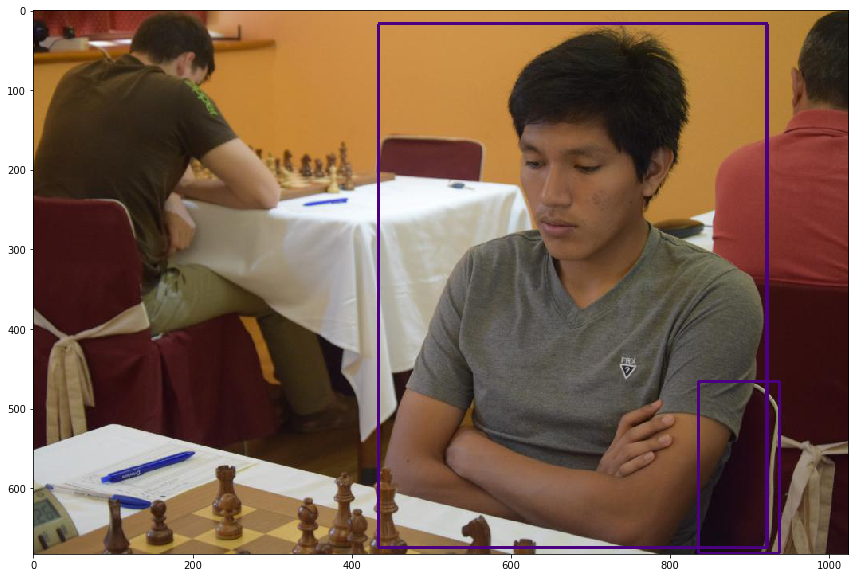

In [167]:
show_tuple_relation(df_test_pos, 34306, test_mode=True)

In [67]:
df_trip = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip.head()

,LabelName1,LabelName2,RelationshipLabel
0,/m/01599,/m/04bcr3,on
1,/m/05r655,/m/0h8my_4,holds
2,/m/05r655,/m/03k3r,on
3,/m/04yx4,/m/0l14j_,holds
4,/m/05r655,/m/080hkjn,wears


In [68]:
df_trip.loc[df_trip.RelationshipLabel=='is'].shape

(42, 3)

In [69]:
df_trip.shape

(329, 3)